# Polynomial Linear Regression

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

This tutorial focusses on regression - that is, fitting curves to datasets. We will look at a simple linear
regression example with `cofi`.

To begin with, we will work with polynomial curves, $$y(x) = \sum_{n=0}^N m_n x^n\,.$$
Here, $N$ is the 'order' of the polynomial: if N=1 we have a straight line, if N=2 it will be a quadratic, and so on. The $m_n$ are the 'model coefficients'.


We have a set of noisy data values, Y, measured at known locations, X, and wish to find the best fit degree 3 polynomial.

The function we are going to fit is: $y=-6-5x+2x^2+x^3$

---

## Table of contents

1. [Import modules](#import)
2. [Define the problem](#problem)
3. [Define the inversion options](#options)
4. [Run the inversion](#inversion)
5. [Check out the result](#result)
6. [A clean version of code above](#review)
7. [Switching to a different inversion approach](#switch)
    1. [optimization](#optimization)
    2. [Sampling](#sampling)

## Introduction <a name="introduction"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines three things: 1) the forward problem; 2) model parameter space (the unknowns); and 3) other information about the inverse problem we are solving, such as the jacobian matrix (i.e. design matrix for our linear problem) for the least squares solver we will be using initially in the following
- `InversionOptions` describes details about how one wants to run the inversion, including the
  inversion approach, backend tool and solver-specific parameters.
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
For each of the above components, there's a `summary()` method to check the current status.
  
So a common workflow includes 4 steps:

1. we begin by defining the `BaseProblem`. This can be done through a series of set functions
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_initial_model(a_starting_point)
    ```
  
2. define `InversionOptions`. Some useful methods include:

    - `set_solving_method()` and `suggest_tools()`. Once you've set a solving method (from "least squares"
      and "optimization", more will be supported), you can use `suggest_tools()` to see a list of backend tools
      to choose from.
      
3. start an `Inversion`. This step is common:

   ```
   inv = Inversion(inv_problem, inv_options)
   result = inv.run()
   ```
   
4. analyse the result, workflow and redo your experiments with different `InversionOptions` objects

---
## 1. Import modules <a name="import"></a>

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from cofi import BaseProblem, InversionOptions, Inversion
from cofi.utils import QuadraticReg

np.random.seed(42)

---
## 2. Define the problem <a name="problem"></a>

Here we compute $y(x)$ for multiple $x$-values simultaneously, so write the forward operator
in the following form:

$$ \left(\begin{array}{c}y_1\\y_2\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_1&x_1^2&x_1^3\\1&x_2&x_2^2&x_2^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$This clearly has the required general form, $\mathbf{y=Gm}$, and so the best-fitting model can be identified using the least-squares algorithm.

In the following code block, we'll define the forward function and generate some random
data points as our dataset.

$$\begin{align}
\text{forward}(\textbf{m}) &= \textbf{G}\textbf{m}\\
&= \text{basis_func}(\textbf{x})\cdot\textbf{m}
\end{align}$$

where:

- $\text{forward}$ is the forward function that takes in a model and produces synthetic data,
- $\textbf{m}$ is the model vector,
- $\textbf{G}$ is the basis matrix (i.e. design matrix) of this linear regression problem and looks like the following: $$\left(\begin{array}{ccc}1&x_1&x_1^2&x_1^3\\1&x_2&x_2^2&x_2^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)$$
- $\text{basis_func}$ is the basis function that converts $\textbf{x}$ into $\textbf{G}$

Recall that the function we are going to fit is: $y=-6-5x+2x^2+x^3$

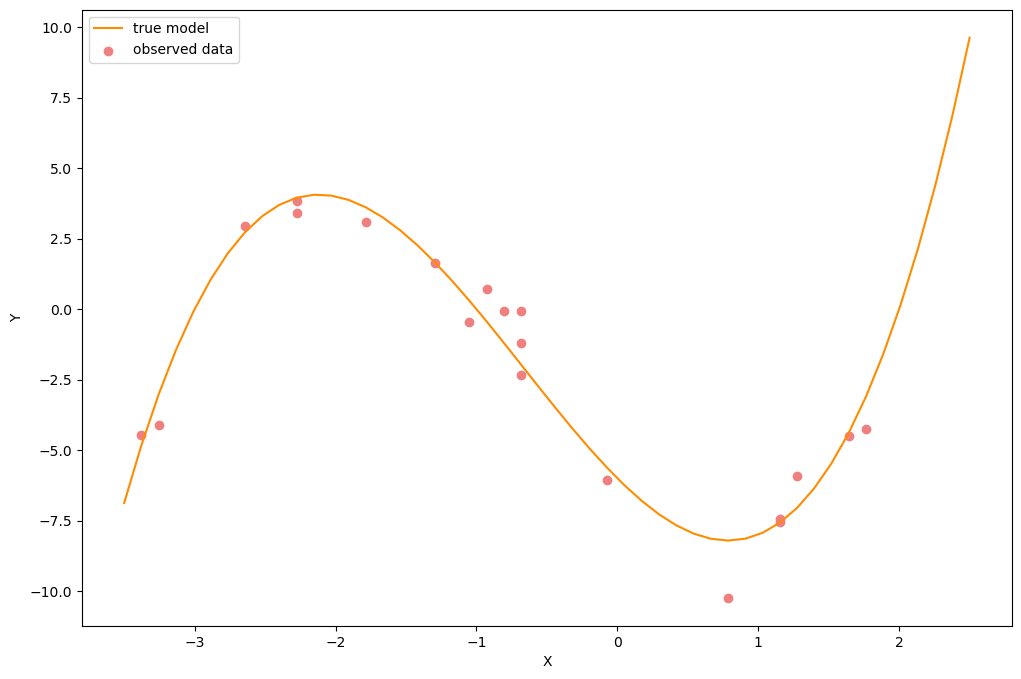

In [3]:
# generate data with random Gaussian noise
def basis_func(x):
    return np.array([x**i for i in range(4)]).T                           # x -> G
_m_true = np.array([-6,-5,2,1])                                           # m
sample_size = 20                                                          # N
x = np.random.choice(np.linspace(-3.5,2.5), size=sample_size)             # x
def forward_func(m):
    return basis_func(x) @ m                                              # m -> y_synthetic
y_observed = forward_func(_m_true) + np.random.normal(0,1,sample_size)    # d

############## PLOTTING ###############################################################
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.scatter(x, y_observed, color="lightcoral", label="observed data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

Now we define the problem in `cofi` - in other words,we set the problem information for a `BaseProblem` object.

From [this page](https://cofi.readthedocs.io/en/latest/api/generated/cofi.BaseProblem.html#set-methods) 
you'll see a list of functions/properties that can be set to `BaseProblem`.

Other helper methods for `BaseProblem` include:

- `defined_components()` (review what have been set)
- `summary()` (better displayed information)
- `suggest_tools()`

We refer readers to [cofi's API reference page](https://cofi.readthedocs.io/en/latest/api/generated/cofi.BaseProblem.html) for 
details about all these methods.

Since we are dealing with a linear problem, the design matrix $\textbf{G}$ is the Jacobian 
of the forward function with respect to the model. This information will be useful when 
the inversion solver is a linear system solver (as we'll demonstrate firstly in the next section).

For a linear system solver, only the data observations vector and the Jacobian matrix are
needed. We thus set them to our `BaseProblem` object.

In [4]:
# define the problem in cofi
inv_problem = BaseProblem()
inv_problem.name = "Polynomial Regression"
inv_problem.set_data(y_observed)
inv_problem.set_jacobian(basis_func(x))

inv_problem.summary()

Summary for inversion problem: Polynomial Regression
Model shape: Unknown
---------------------------------------------------------------------
List of functions/properties set by you:
['jacobian', 'data']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['jacobian_times_vector']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data_covariance', 'data_covariance_inv', 'initial_model', 'model_shape', 'blobs_dtype', 'bounds', 'constraints']


---
## 3. Define the inversion options <a name="options"></a>

As mentioned above, an `InversionOptions` object contains everything you'd like to define
regarding how the inversion is to be run.

From [this page](https://cofi.readthedocs.io/en/latest/api/generated/cofi.InversionOptions.html)
you'll see the methods for `InversionOptions`.

In general:
1. we use `InversionOptions.set_tool("tool_name")` to set which backend tool
you'd like to use
2. then with `InversionOptions.set_params(p1=val1, p2=val2, ...)`
you can set solver-specific parameters.

In [5]:
inv_options = InversionOptions()
inv_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_opt_min.ScipyOptMin'> (by default)` - SciPy's optimizers that minimizes a scalar function with respect to one or more variables, check SciPy's documentation page for a list of methods
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


We have a **suggesting system** that is being improved at the moment, so that you can see
what backend tools are available based on the categories of inversion approaches
you'd like to use.

In [6]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee"
    ]
}


Having seen what a default `InversionOptions` object look like, we customise the inversion
process by constraining the solving approach:

In [7]:
inv_options.set_solving_method("matrix solvers")
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'> (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


---

As the "summary" suggested, you've set the solving method, so you can skip the step of
setting a backend tool because there's a default one.

If there are more than one backend tool options, then the following function shows available
options and set your desired backend solver.

In [8]:
inv_options.suggest_tools()

Based on the solving method you've set, the following tools are suggested:
['scipy.linalg.lstsq', 'cofi.simple_newton']

Use `InversionOptions.set_tool(tool_name)` to set a specific tool from above
Use `InversionOptions.set_solving_method(method_name)` to change solving method
Use `InversionOptions.unset_solving_method()` if you'd like to see more options
Check CoFI documentation 'Advanced Usage' section for how to plug in your own tool or solver


You can also set the backend tool directly (as following), without the call to
`inv_options.set_solving_method()` above.

In [9]:
inv_options.set_tool("scipy.linalg.lstsq")
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'>` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


---
## 4. Start an inversion <a name="inversion"></a>

This step is common for most cases. We've specified our problem as a `BaseProblem` object,
and we've defined how to run the inversion as an `InversionOptions` object.

Taking them both in, an `Inversion` object knows all the information and is an engine to actually 
perform the inversion.

In [10]:
inv = Inversion(inv_problem, inv_options)
inv.summary()

Summary for Inversion
Inversion hasn't started, try `inversion.run()` to see result
---------------------------------------
With inversion solver defined as below:

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'>` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.
---------------------------------------
For inversion problem defined as below:

Summary for inversion problem: Polynomial Regression
Model shape: Unknown
List of functions/properties set by y

Now, let's run it!

In [11]:
inv_result = inv.run()
inv_result.success

True

The inversion result returned by `inv.run()` is an instance of `InversionResult`.

See [this documentation page](https://cofi.readthedocs.io/en/latest/api/generated/cofi.InversionResult.html)
for details about what can be done with the resulting object.

Results returned by different backend tools will have different extra information.
But there are two common things - they all have a `success` status (as a boolean)
and a `model`/`sampler` result.

Similar to the other class objects, you can see what's inside it with the `summary()` method.

In [12]:
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
model: [-5.71964359 -5.10903808  1.82553662  0.97472374]
sum_of_squared_residuals: []
effective_rank: 4
singular_values: [3765.51775745   69.19268194   16.27124488    3.85437889]


---
## 5. Check back your problem setting, inversion setting & result <a name="result"></a>

A summary view of the `Inversion` object shows information about the whole inversion
process, including how the problem is defined, how the inversion is defined to be run,
as well as what the results are (if any).

In [13]:
inv.summary()

Summary for Inversion
Completed with the following result:

Summary for inversion result
SUCCESS
model: [-5.71964359 -5.10903808  1.82553662  0.97472374]
sum_of_squared_residuals: []
effective_rank: 4
singular_values: [3765.51775745   69.19268194   16.27124488    3.85437889]
---------------------------------------
With inversion solver defined as below:

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'>` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


Now, let's plot the predicted curve and compare it to the data and ground truth.

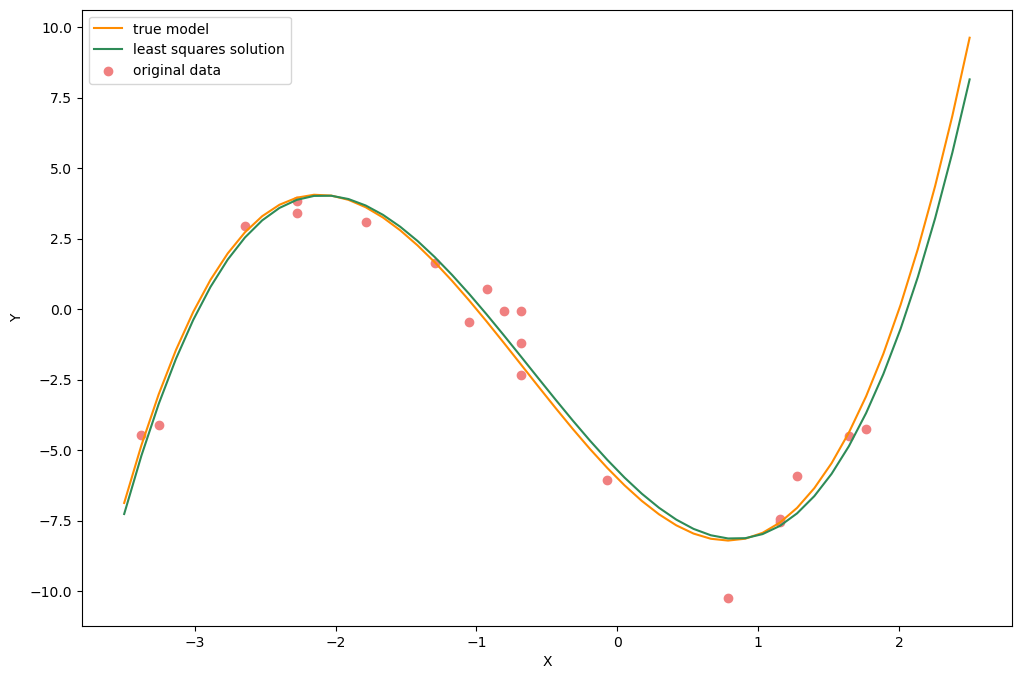

In [14]:
y_synthetic = forward_func(inv_result.model)

############## PLOTTING ###############################################################
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
_y_synth = _G_plot @ inv_result.model
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.plot(_x_plot, _y_synth, color="seagreen", label="least squares solution")
plt.scatter(x, y_observed, color="lightcoral", label="original data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

Here we see the least squares solver (green curve) fits all of the data well and is a close approximation of the true curve (orange).

---
## 6. Summary: a cleaner version of the above example <a name="review"></a>

For review purpose, here are the minimal set of commands we've used to produce the above result:

In [15]:
######## Import and set random seed
import numpy as np
from cofi import BaseProblem, InversionOptions, Inversion

np.random.seed(42)

######## Write code for your forward problem
_m_true = np.array([-6,-5,2,1])                                            # m
_sample_size = 20                                                          # N
x = np.random.choice(np.linspace(-3.5,2.5), size=_sample_size)             # x
def basis_func(x):
    return np.array([x**i for i in range(4)]).T                            # x -> G
def forward_func(m): 
    return (np.array([x**i for i in range(4)]).T) @ m                      # m -> y_synthetic
y_observed = forward_func(_m_true) + np.random.normal(0,1,_sample_size)    # d

######## Attach above information to a `BaseProblem`
inv_problem = BaseProblem()
inv_problem.name = "Polynomial Regression"
inv_problem.set_data(y_observed)
inv_problem.set_jacobian(basis_func(x))

######## Specify how you'd like the inversion to run (via an `InversionOptions`)
inv_options = InversionOptions()
inv_options.set_tool("scipy.linalg.lstsq")

######## Pass `BaseProblem` and `InversionOptions` into `Inversion` and run
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

######## Now check out the result
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [-5.71964359 -5.10903808  1.82553662  0.97472374]

Summary for inversion result
SUCCESS
----------------------------
model: [-5.71964359 -5.10903808  1.82553662  0.97472374]
sum_of_squared_residuals: []
effective_rank: 4
singular_values: [3765.51775745   69.19268194   16.27124488    3.85437889]


---
## 7. Switching to a different inversion approach <a name="switching"></a>

We've seen how this linear regression problem is solved with a linear system solver.
It's time to see `cofi`'s capability to switch between different inversion approaches
easily. 

### 7.1. optimization <a name="optimization"></a>

Any linear problem $\textbf{y} = \textbf{G}\textbf{m}$ can also be solved by minimizing the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{r}$ where 
$\textbf{r}=\textbf{y}-\textbf{G}\textbf{m}$.

So we first use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularization. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI.

In [16]:
######## Provide additional information
inv_problem.set_initial_model(np.ones(4))
inv_problem.set_forward(forward_func)
inv_problem.set_data_misfit("least squares")
inv_problem.set_regularization(0.02 * QuadraticReg(model_shape=(4,)))      # optional

######## Set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")

######## Run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## Check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [-5.68862266 -5.09203993  1.81066089  0.96922711]

Summary for inversion result
SUCCESS
----------------------------
fun: 16.217557592947745
jac: [ 0.00000000e+00  2.38418579e-07 -4.76837158e-07 -2.38418579e-07]
hess_inv: [[ 0.09466099  0.02886397 -0.0406164  -0.01267773]
 [ 0.02886397  0.04324386 -0.01646474 -0.00902502]
 [-0.0406164  -0.01646474  0.0258144   0.00848302]
 [-0.01267773 -0.00902502  0.00848302  0.00336663]]
nfev: 55
njev: 11
status: 0
message: Optimization terminated successfully.
nit: 8
model: [-5.68862266 -5.09203993  1.81066089  0.96922711]


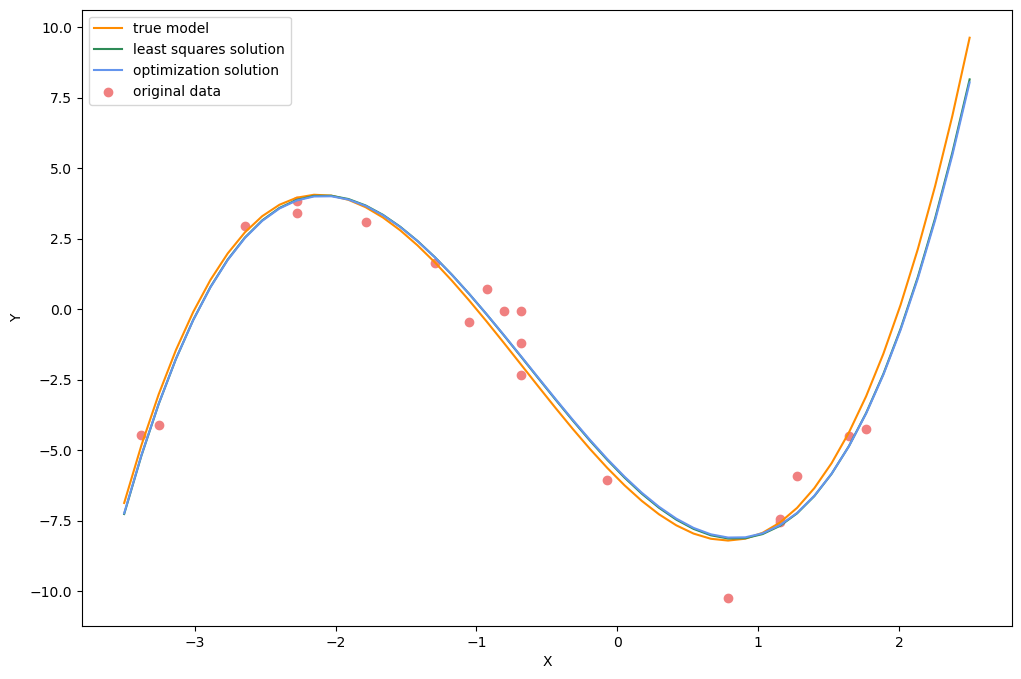

In [17]:
######## Plot all together
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
_y_synth = _G_plot @ inv_result.model
_y_synth_2 = _G_plot @ inv_result_2.model
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.plot(_x_plot, _y_synth, color="seagreen", label="least squares solution")
plt.plot(_x_plot, _y_synth_2, color="cornflowerblue", label="optimization solution")
plt.scatter(x, y_observed, color="lightcoral", label="original data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

Here we see the  (blue curve) is also a relatively good approximation of the true curve (orange).

### 7.2. Sampling <a name="sampling"></a>

We've seen the same regression problem solved with a linear system solver and an optimizer -
how about sampling?

#### Background (if you're relatively new to this)

Before we show you an example of how to solve this problem from a Bayesian sampling perspective,
let's switch to a slightly different mindset:

1. Instead of getting a result as a **single "best-fit"** model, it's worthwhile to obtain an 
   **ensemble** of models
2. How to *express* such an ensemble of models? It's uncertain where the true model is, 
   but given a) the data and b) some prior knowledge about the model, we can express it as a 
   **probability distribution**, where $p(\text{model})$ is the probability at which the $\text{model}$
   is true.
3. How to *estimate* this distribution then? There are various ways, and **sampling** is a typical one
   of them.
   
In a sampling approach, there are typically multiple walkers that start from some initial points
(initial guesses of the models) and take steps in the model space (the set of all possible models).
With a Markov chain Monte Carlo (McMC) sampler, the walkers move step by step, and determine whether
to keep the new sample based on evaluation of the posterior probability density we provide, with 
some randomness.

The sampler seeks to recover the unknown **posterior distribution** as efficiently as possible and 
different samplers employ different strategies to determine a step (i.e. perturbation to the current 
model) that finds a balance between the exploration and exploitation.

Starting from the **Bayes theorem**:
$$
p(A|B) = \frac{p(B|A)p(A)}{p(B)}
$$

The unknowns are model parameters, so we set $A$ to be $\textbf{m}$ (model), and $B$ to be 
$\textbf{d}$ (data). Since the marginal distribution $p(\textbf{d})$ is assumed to be unrelated 
to the $\textbf{m}$, we get the following relationship:
$$
p(\textbf{m}|\textbf{d}) \propto p(\textbf{d}|\textbf{m}) p(\textbf{m})
$$

where:

- $p(\textbf{m}|\textbf{d})$ (posterior) is the probability of a model given data observations
- $p(\textbf{d}|\textbf{m})$ (likelihood) is the probability of which data is observed given a certain model
- $p(\textbf{m})$ (prior) is the probability of a certain model and reflects your belief / domain knowledge
  on the model
  
#### Coding

Most sampler tools require the logarithm of the probability. 
$$
\log(\text{posterior}) = \log(\text{likelihood}) + \log(\text{prior})
$$

So in `cofi`, you can either define:

- log of the posterior, using `BaseProblem.set_log_posterior` ([ref](https://cofi.readthedocs.io/en/latest/api/generated/cofi.BaseProblem.html#cofi.BaseProblem.set_log_posterior)), or
- log of prior and log of likelihood, using `BaseProblem.set_log_prior()` ([ref](https://cofi.readthedocs.io/en/latest/api/generated/cofi.BaseProblem.html#cofi.BaseProblem.set_log_prior)) and `BaseProblem.set_log_likelihood()` ([ref](https://cofi.readthedocs.io/en/latest/api/generated/cofi.BaseProblem.html#cofi.BaseProblem.set_log_likelihood))

We use the second option in this demo.

##### Likelihood

To measure the probability of the observed y values given those predicted by our polynomial curve we specify a Likelihood function $p({\mathbf d}_{obs}| {\mathbf m})$ 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given an  model. For sampling we will only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

In [18]:
sigma = 1.0                                     # common noise standard deviation
Cdinv = np.eye(len(y_observed))/(sigma**2)      # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward_func(model)
    residual = y_observed - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

##### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. There are two common choices. 

The first is to make the prior uniform with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

The second choice is to make the prior an unbounded Gaussian 

$$
p({\mathbf m}) \propto \exp \left\{- \frac{1}{2}({\mathbf m}-{\mathbf m}_o)^T C_M^{-1}({\mathbf m}-{\mathbf m}_o)
\right\},
$$

where ${\mathbf m}_o)$ is some reference set of model coefficients, and $C_M^{-1}$ is an inverse model covariance describing prior information for each model parameter.

Here we choose a Uniform prior with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [19]:
m_lower_bound = np.ones(4) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(4) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

##### Walkers' starting points

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [20]:
nwalkers = 32
ndim = 4
nsteps = 5000
walkers_start = np.array([0.,0.,0.,0.]) + 1e-4 * np.random.randn(nwalkers, ndim)

Finally, we attach all above information to our `BaseProblem` and `InversionOptions` objects.

In [21]:
######## Provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## Set a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, initial_state=walkers_start)

######## Run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## Check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


#### Analyse sampling results

Sampler is complete. We do not know if there have been enough walkers or enough samplers 
but we'll have a look at these results, using some standard approaches.

As you've seen above, `inv_result_3` has a `sampler` attribute attached to it, and this
contains all the information from backend sampler, including the chains on each walker, 
their associated posterior value, etc. You get to access all the raw data directly by
exploring this `inv_result_3.sampler` object.

Additionally, we can convert a sampler object into an instance of 
`arviz.InferenceData` ([ref](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.html#arviz.InferenceData)),
so that all the plotting functions from [arviz](https://python.arviz.org/en/latest/index.html) are exposed.

In [22]:
sampler = inv_result_3.sampler
az_idata = inv_result_3.to_arviz()

##### Sampling performance

Let’s take a look at what the sampler has done. A good first step is to look at the time series of the parameters in the chain. The samples can be accessed using the `EnsembleSampler.get_chain()` method. This will return an array with the shape (5000, 32, 3) giving the parameter values for each walker at each step in the chain. The figure below shows the positions of each walker as a function of the number of steps in the chain:

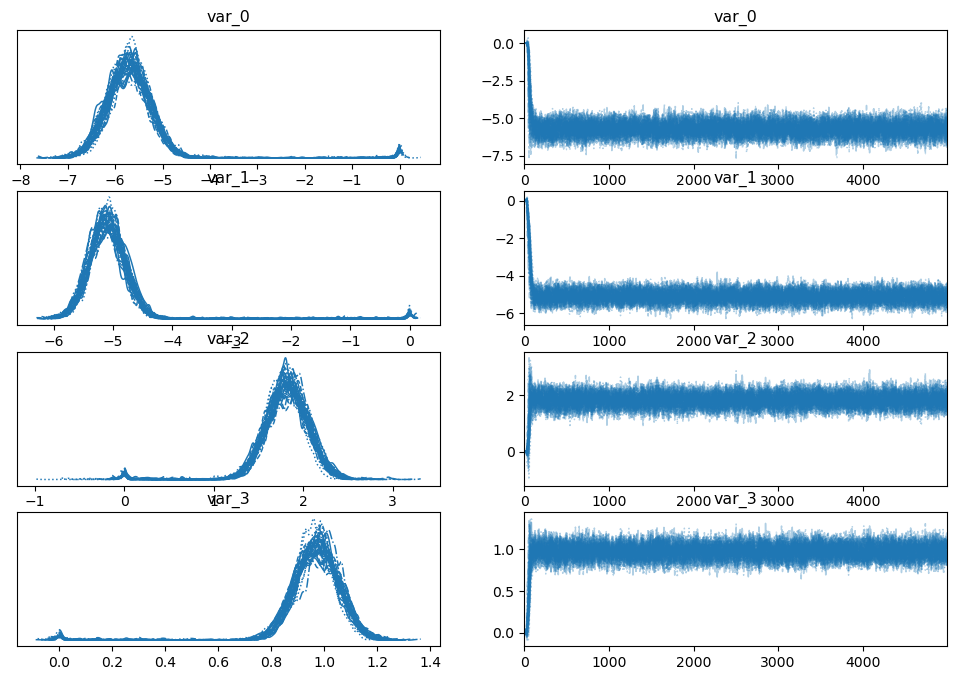

In [23]:
labels = ["m0", "m1", "m2","m3"]
az.plot_trace(az_idata);

##### Autocorrelation analysis

As mentioned above, the walkers start in small distributions around some chosen values and then they quickly wander and start exploring the full posterior distribution. In fact, after a relatively small number of steps, the samples seem pretty well “burnt-in”. That is a hard statement to make quantitatively, but we can look at an estimate of the integrated autocorrelation time (see Emcee's package the -[*Autocorrelation analysis & convergence tutorial*](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) for more details):

In [24]:
tau = sampler.get_autocorr_time()
print(f"autocorrelation time: {tau}")

autocorrelation time: [60.06623419 66.33363928 45.80483908 52.6256319 ]


##### Corner plot

The above suggests that only about 70 steps are needed for the chain to “forget” where it started. It’s not unreasonable to throw away a few times this number of steps as “burn-in”.

Let’s discard the initial 300 steps, and thin by about half the autocorrelation time (30 steps).

Let’s make one of the most useful plots you can make with your MCMC results: a corner plot.

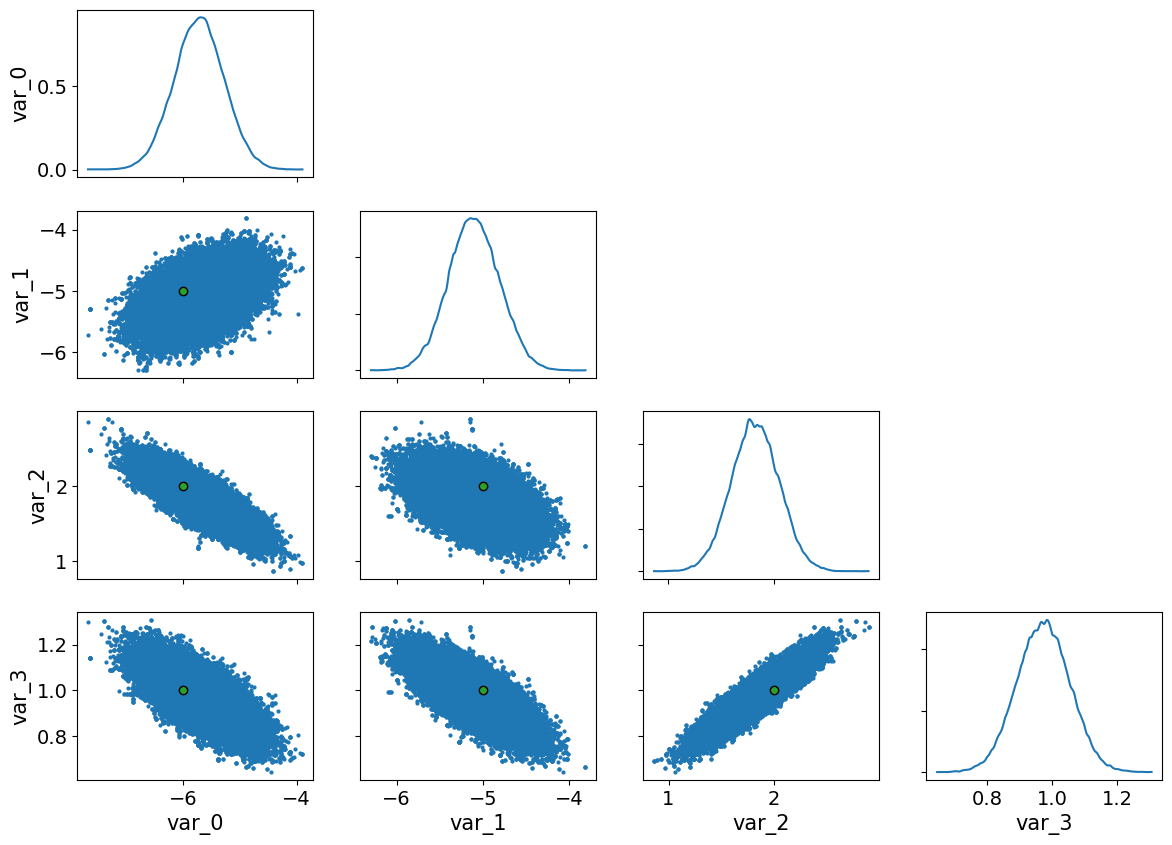

In [25]:
_, axes = plt.subplots(4, 4, figsize=(14,10))
az.plot_pair(
    az_idata.sel(draw=slice(300,None)), 
    marginals=True, 
    reference_values=dict(zip([f"var_{i}" for i in range(4)], _m_true.tolist())),
    ax = axes
);

The corner plot shows all the one and two dimensional projections of the posterior probability distributions of your parameters. This is useful because it quickly demonstrates all of the covariances between parameters. Also, the way that you find the marginalized distribution for a parameter or set of parameters using the results of the MCMC chain is to project the samples into that plane and then make an N-dimensional histogram. That means that the corner plot shows the marginalized distribution for each parameter independently in the histograms along the diagonal and then the marginalized two dimensional distributions in the other panels.

##### Predicted curves

Now lets plot the a sub-sample of 100 the predicted curves from this posterior ensemble and compare to the data.

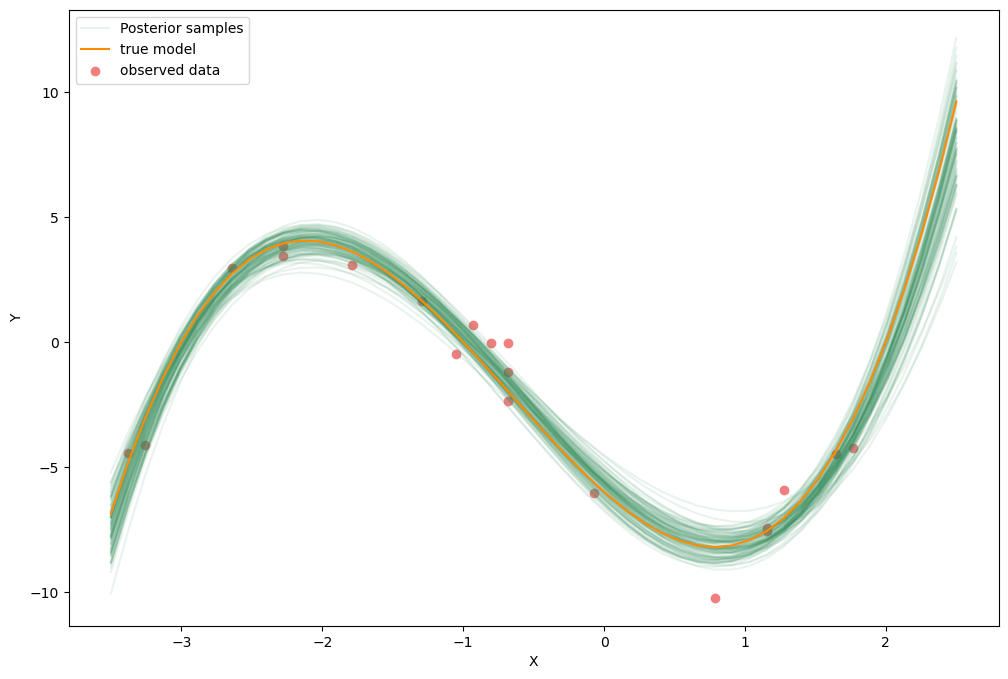

In [26]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
plt.figure(figsize=(12,8))
sample = flat_samples[0]
_y_synth = _G_plot @ sample
plt.plot(_x_plot, _y_synth, color="seagreen", label="Posterior samples",alpha=0.1)
for ind in inds:
    sample = flat_samples[ind]
    _y_synth = _G_plot @ sample
    plt.plot(_x_plot, _y_synth, color="seagreen", alpha=0.1)
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.scatter(x, y_observed, color="lightcoral", label="observed data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

##### Uncertainty estimates

We can now calculate some formal uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions.

In [27]:
solmed = np.zeros(4)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    solmed[i] = mcmc[1]
    q = np.diff(mcmc)
    # txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}} "
    # txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    # display(Math(txt))
    print(f"{labels[i]} = {round(mcmc[1],3)}, (-{round(q[0],3)}, +{round(q[1],3)})")

m0 = -5.717, (-0.423, +0.431)
m1 = -5.108, (-0.287, +0.291)
m2 = 1.818, (-0.217, +0.229)
m3 = 0.973, (-0.079, +0.08)


The first number here is the median value of each model coefficient in the posterior ensemble, while the upper and lower numbers correspond to the differences between the median and the 16th and 84th percentile. Recall here that the true values were
$m_0 = -6, m_1 = -5, m_2= 2,$ and $m_3 = 1$. So all are close to the median and lie within the credible intervals.

We can also calculate the posterior model covariance matrix and compare to that estimated by least squares.

In [28]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))
    
inv_problem.set_data_covariance_inv(Cdinv)
CMlstsq = inv_problem.model_covariance(None)
print('\nModel covariance matrix estimated by least squares\n', CMlstsq)

Posterior model covariance matrix
 [[ 0.18990987  0.05884848 -0.08062154 -0.02514717]
 [ 0.05884848  0.08758844 -0.03294044 -0.01812487]
 [-0.08062154 -0.03294044  0.05025757  0.01649417]
 [-0.02514717 -0.01812487  0.01649417  0.00657754]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.4357
    m1  0.2959
    m2  0.2242
    m3  0.0811

Model covariance matrix estimated by least squares
 [[ 0.19027447  0.05812534 -0.08168411 -0.02550866]
 [ 0.05812534  0.08673796 -0.03312809 -0.01812686]
 [-0.08168411 -0.03312809  0.05184851  0.01704165]
 [-0.02550866 -0.01812686  0.01704165  0.00676031]]


In [29]:
print("\n Solution and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Solution and 95% credible intervals 
 m0  -5.717 [ -6.434,  -5.006]
 m1  -5.108 [ -5.596,  -4.621]
 m2   1.818 [  1.462,   2.183]
 m3   0.973 [  0.844,   1.109]


---

## Watermark

In [30]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.0
numpy 1.23.5
scipy 1.10.1
matplotlib 3.7.1
emcee 3.1.4
arviz 0.15.1
